# Hamiltonian-Monte-Carlo

This tutorial shows how to sample from a target distribution via HMC as implemented in class [HMC](../utils/hmc.py).

Note, parameters in this notebook have not been properly tuned. The tutorial should show the usage of the HMC code and not the capabilities of the algorithm.

In [1]:
from argparse import Namespace
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import torch
from torch.distributions import MultivariateNormal, Normal

from hypnettorch.data.special.regression1d_data import ToyRegression
from hypnettorch.data.special.gaussian_mixture_data import GaussianData
from hypnettorch.mnets import MLP
from hypnettorch.utils.hmc import HMC, MCMC, MultiChainHMC, NUTS, nn_pot_energy, log_prob_standard_normal_prior
from hypnettorch.utils.sim_utils import setup_environment

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Create output directory and other helpers.
config = Namespace()
config.out_dir = './hmc_tutorial'
config.loglevel_info = False
config.random_seed = 42
config.use_cuda = False # CPU usually faster for simple problems.
config.deterministic_run = True
# Delete file from previous tutorial session:
if os.path.exists(config.out_dir):
    shutil.rmtree(config.out_dir)
device, writer, logger = setup_environment(config, logger_name='hmc_logger')

Created output folder ./hmc_tutorial.
10/06/2021 06:17:40 PM - INFO - Using cuda: False


## Sample with HMC from a 2D Gaussian

As a first sanity check, we use HMC to gather samples from a 2D Gaussian distribution.

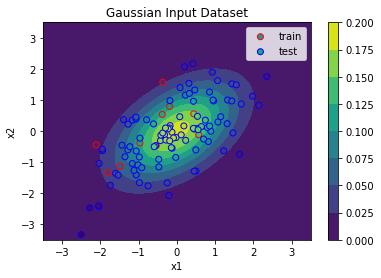

In [2]:
mean = np.array([0., 0.])
cov = np.array([[1., .5], [.5, 1.]])
# Create our data handler to get nice visualizations ;)
target_data = GaussianData(mean=mean, cov=cov, num_train=10, num_test=100, rseed=32)
_ = target_data.plot_dataset()
# Create the same distribution in Torch.
target_dist = MultivariateNormal(torch.from_numpy(mean).to(device), torch.from_numpy(cov).to(device))

Now, we are ready to obtain samples via our HMC implementation. The plot below shows the samples retrieved via HMC in black (only samples after burn-in are drawn).

10/06/2021 06:17:40 PM - DEBUG - HMC state 1: Current Hamiltonian: 1.813042 - Acceptance probability: 100.00%.
10/06/2021 06:17:40 PM - DEBUG - HMC state 11: Current Hamiltonian: 2.710688 - Acceptance probability: 100.00%.
10/06/2021 06:17:40 PM - DEBUG - HMC state 21: Current Hamiltonian: 12.389607 - Acceptance probability: 100.00%.
10/06/2021 06:17:40 PM - DEBUG - HMC state 31: Current Hamiltonian: 2.225326 - Acceptance probability: 100.00%.
10/06/2021 06:17:40 PM - DEBUG - HMC state 41: Current Hamiltonian: 2.882206 - Acceptance probability: 100.00%.
10/06/2021 06:17:41 PM - DEBUG - HMC state 51: Current Hamiltonian: 2.150697 - Acceptance probability: 100.00%.
10/06/2021 06:17:41 PM - DEBUG - HMC state 61: Current Hamiltonian: 2.527100 - Acceptance probability: 100.00%.
10/06/2021 06:17:41 PM - DEBUG - HMC state 71: Current Hamiltonian: 2.284668 - Acceptance probability: 100.00%.
10/06/2021 06:17:41 PM - DEBUG - HMC state 81: Current Hamiltonian: 4.251857 - Acceptance probability: 1

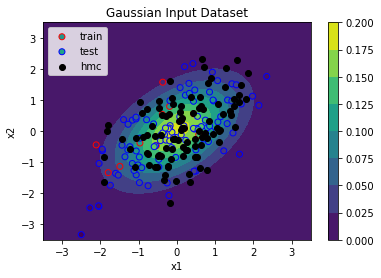

In [3]:
hmc = HMC(target_dist.sample(), lambda q : -target_dist.log_prob(q), stepsize=.05, num_steps=25, 
          inv_mass=1., logger=logger, log_interval=10, writer=writer,
          writer_tag='gauss2d/')
hmc.simulate_chain(150)
print('Overall Acceptance Probability: %.2f%%' % (hmc.acceptance_probability * 100))

hmc_samples = np.stack([p.detach().cpu().numpy() for p in hmc.position_trajectory])

_ = target_data.plot_dataset(show=False)
burn_in = 50
plt.scatter(hmc_samples[burn_in:, 0], hmc_samples[burn_in:, 1], label='hmc', color='k')
plt.legend()
plt.show()

For comparison, below is the standard random walk MCMC.

10/06/2021 06:17:42 PM - DEBUG - MH state 1: Current Pot. Energy: 1.719562 - Acceptance probability: 100.00%.
10/06/2021 06:17:42 PM - DEBUG - MH state 11: Current Pot. Energy: 3.551182 - Acceptance probability: 81.82%.
10/06/2021 06:17:42 PM - DEBUG - MH state 21: Current Pot. Energy: 2.007208 - Acceptance probability: 76.19%.
10/06/2021 06:17:42 PM - DEBUG - MH state 31: Current Pot. Energy: 1.810204 - Acceptance probability: 83.87%.
10/06/2021 06:17:42 PM - DEBUG - MH state 41: Current Pot. Energy: 2.958429 - Acceptance probability: 85.37%.
10/06/2021 06:17:42 PM - DEBUG - MH state 51: Current Pot. Energy: 4.025550 - Acceptance probability: 80.39%.
10/06/2021 06:17:42 PM - DEBUG - MH state 61: Current Pot. Energy: 4.494681 - Acceptance probability: 80.33%.
10/06/2021 06:17:42 PM - DEBUG - MH state 71: Current Pot. Energy: 4.761237 - Acceptance probability: 78.87%.
10/06/2021 06:17:42 PM - DEBUG - MH state 81: Current Pot. Energy: 2.157617 - Acceptance probability: 77.78%.
10/06/2021

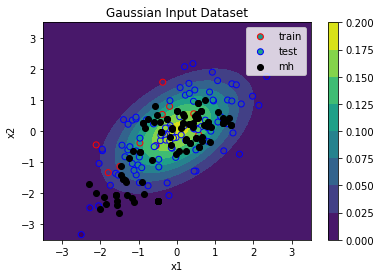

In [4]:
mh = MCMC(target_dist.sample(), lambda q : -target_dist.log_prob(q), proposal_std=.5, logger=logger, log_interval=10, writer=writer,
          writer_tag='mh/gauss2d/')
mh.simulate_chain(150)
print('Overall Acceptance Probability: %.2f%%' % (mh.acceptance_probability * 100))

mh_samples = np.stack([p.detach().cpu().numpy() for p in mh.position_trajectory])

_ = target_data.plot_dataset(show=False)
burn_in = 50
plt.scatter(mh_samples[burn_in:, 0], mh_samples[burn_in:, 1], label='mh', color='k')
plt.legend()
plt.show()

## 1D Gaussian - Sanity check

As a sanity check, we sample from a standard 1D Gaussian via HMC. If enough samples are drawn, the overlay of histograms with samples from HMC and directly drawn samples should look similar.

10/06/2021 06:17:42 PM - DEBUG - HMC state 1: Current Hamiltonian: 1.262708 - Acceptance probability: 100.00%.
10/06/2021 06:17:43 PM - DEBUG - HMC state 101: Current Hamiltonian: 2.179882 - Acceptance probability: 100.00%.
10/06/2021 06:17:43 PM - DEBUG - HMC state 201: Current Hamiltonian: 1.229419 - Acceptance probability: 100.00%.
10/06/2021 06:17:44 PM - DEBUG - HMC state 301: Current Hamiltonian: 2.287404 - Acceptance probability: 100.00%.
10/06/2021 06:17:44 PM - DEBUG - HMC state 401: Current Hamiltonian: 1.520626 - Acceptance probability: 100.00%.
10/06/2021 06:17:45 PM - DEBUG - HMC state 501: Current Hamiltonian: 4.302558 - Acceptance probability: 100.00%.
10/06/2021 06:17:46 PM - DEBUG - HMC state 601: Current Hamiltonian: 1.733045 - Acceptance probability: 100.00%.
10/06/2021 06:17:46 PM - DEBUG - HMC state 701: Current Hamiltonian: 1.525711 - Acceptance probability: 100.00%.
10/06/2021 06:17:47 PM - DEBUG - HMC state 801: Current Hamiltonian: 1.368598 - Acceptance probabi

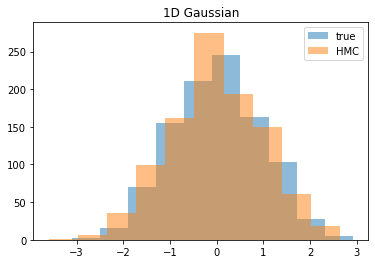

In [5]:
target_dist = Normal(torch.zeros(1,).to(device), 1.)
target_samples = target_dist.sample((1000,))

burn_in = 50

hmc = HMC(target_dist.sample(), lambda q : -target_dist.log_prob(q), stepsize=.05, num_steps=25, 
          inv_mass=1., logger=logger, log_interval=100, writer=writer,
          writer_tag='gauss1d/')
hmc.simulate_chain(1000+burn_in)
print('Overall Acceptance Probability: %.2f%%' % (hmc.acceptance_probability * 100))

hmc.clear_position_trajectory(n=burn_in)
hmc_samples = torch.cat(hmc.position_trajectory).detach().cpu().numpy()

print('Empirical mean: true samples %f - HMC samples %f' % (target_samples.mean().item(), hmc_samples.mean().item()))
print('Empirical std: true samples %f - HMC samples %f' % (target_samples.std().item(), hmc_samples.std().item()))

plt.title('1D Gaussian')
plt.hist(target_samples.cpu().numpy(), alpha=.5, label='true')
plt.hist(hmc_samples, alpha=.5, label='HMC')
plt.legend()
plt.show()

Again, we provide the same sanity check using the basic Metropolis-Hastings algorithm.

10/06/2021 06:17:48 PM - DEBUG - MH state 1: Current Pot. Energy: 0.919427 - Acceptance probability: 100.00%.
10/06/2021 06:17:48 PM - DEBUG - MH state 101: Current Pot. Energy: 1.096723 - Acceptance probability: 82.18%.
10/06/2021 06:17:48 PM - DEBUG - MH state 201: Current Pot. Energy: 0.919739 - Acceptance probability: 86.57%.
10/06/2021 06:17:48 PM - DEBUG - MH state 301: Current Pot. Energy: 0.939655 - Acceptance probability: 86.38%.
10/06/2021 06:17:49 PM - DEBUG - MH state 401: Current Pot. Energy: 2.006061 - Acceptance probability: 84.54%.
10/06/2021 06:17:49 PM - DEBUG - MH state 501: Current Pot. Energy: 1.218944 - Acceptance probability: 84.83%.
10/06/2021 06:17:49 PM - DEBUG - MH state 601: Current Pot. Energy: 0.923690 - Acceptance probability: 84.19%.
10/06/2021 06:17:49 PM - DEBUG - MH state 701: Current Pot. Energy: 0.922087 - Acceptance probability: 84.17%.
10/06/2021 06:17:49 PM - DEBUG - MH state 801: Current Pot. Energy: 1.909502 - Acceptance probability: 84.27%.
10

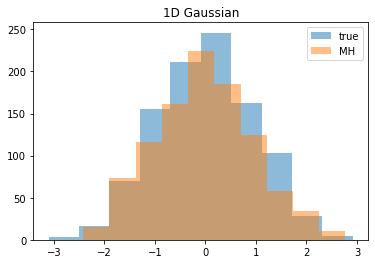

In [6]:
burn_in = 50

mh = MCMC(target_dist.sample(), lambda q : -target_dist.log_prob(q), proposal_std=.5,
          logger=logger, log_interval=100, writer=writer, writer_tag='mh/gauss1d/')
mh.simulate_chain(1000+burn_in)
print('Overall Acceptance Probability: %.2f%%' % (mh.acceptance_probability * 100))

mh.clear_position_trajectory(n=burn_in)
mh_samples = torch.cat(mh.position_trajectory).detach().cpu().numpy()

print('Empirical mean: true samples %f - MH samples %f' % (target_samples.mean().item(), mh_samples.mean().item()))
print('Empirical std: true samples %f - MH samples %f' % (target_samples.std().item(), mh_samples.std().item()))

plt.title('1D Gaussian')
plt.hist(target_samples.cpu().numpy(), alpha=.5, label='true')
plt.hist(mh_samples, alpha=.5, label='MH')
plt.legend()
plt.show()

## Bayesian Neural Network

In this example, we train a simple MLP on a noisy 1D regression task (e.g., see Fig. 2 [here](https://www.zora.uzh.ch/id/eprint/168578/1/121.pdf)). Let's first create the dataset and network.

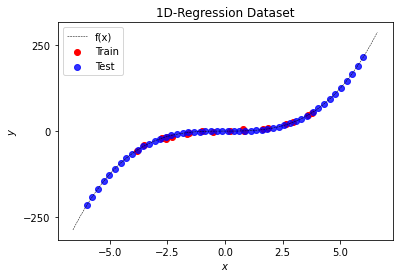

Creating an MLP with 301 weights.


In [7]:
data = ToyRegression(train_inter=[-4, 4], num_train=20, test_inter=[-6, 6], num_test=50,
                     val_inter=[-4, 4], num_val=0, map_function=lambda x : (x**3.), std=3., rseed=42)
data.plot_dataset(show=True)

net = MLP(n_in=1, n_out=1, hidden_layers=(100,),
          activation_fn=torch.nn.ReLU(), use_bias=True).to(device)

Now, we need to define the potential energy. Luckily, our implementation provides an easy handle for this. We assume the standard $\mathcal{N}(0, 1)$ prior.

In [8]:
# Training data.
train_x = data.input_to_torch_tensor(data.get_train_inputs(), device, mode='train')
train_y = data.output_to_torch_tensor(data.get_train_outputs(), device, mode='train')

# Define potential energy.
prior_log_prob_func = lambda q: log_prob_standard_normal_prior(q, mean=0., std=1.)
pot_energy_func = nn_pot_energy(net, train_x, train_y, prior_log_prob_func, tau_pred=1./(3.**2),
                                    nll_type='regression')
# Reinitialize network randomly and use init as initial position.
net.custom_init()
initial_position = MLP.flatten_params(net.internal_params)

# Generate chain and simulate.
hmc = HMC(initial_position, pot_energy_func, stepsize=.02, num_steps=25, 
          inv_mass=1., logger=logger, log_interval=50, writer=writer,
          writer_tag='reg1d/')
hmc.simulate_chain(1000)
print('Overall Acceptance Probability: %.2f%%' % (hmc.acceptance_probability * 100))

10/06/2021 06:17:50 PM - DEBUG - HMC state 1: Current Hamiltonian: 1197.971436 - Acceptance probability: 100.00%.
10/06/2021 06:17:51 PM - DEBUG - HMC state 51: Current Hamiltonian: 639.122498 - Acceptance probability: 88.24%.
10/06/2021 06:17:52 PM - DEBUG - HMC state 101: Current Hamiltonian: 670.776428 - Acceptance probability: 90.10%.
10/06/2021 06:17:53 PM - DEBUG - HMC state 151: Current Hamiltonian: 622.139465 - Acceptance probability: 90.73%.
10/06/2021 06:17:54 PM - DEBUG - HMC state 201: Current Hamiltonian: 624.227966 - Acceptance probability: 91.04%.
10/06/2021 06:17:54 PM - DEBUG - HMC state 251: Current Hamiltonian: 592.779480 - Acceptance probability: 91.24%.
10/06/2021 06:17:55 PM - DEBUG - HMC state 301: Current Hamiltonian: 636.020447 - Acceptance probability: 90.70%.
10/06/2021 06:17:56 PM - DEBUG - HMC state 351: Current Hamiltonian: 639.974304 - Acceptance probability: 90.31%.
10/06/2021 06:17:57 PM - DEBUG - HMC state 401: Current Hamiltonian: 612.492737 - Accepta

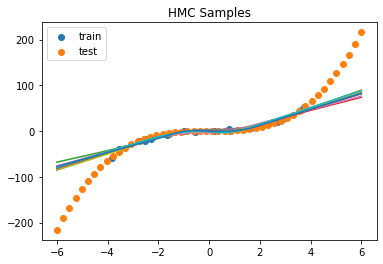

In [9]:
# Plot a few example states from the chain.
hmc_samples = [MLP.flatten_params(p, param_shapes=net.param_shapes, unflatten=True) for p in hmc.position_trajectory]
burn_in = 50
hmc_samples = hmc_samples[burn_in:]

test_x = data.input_to_torch_tensor(data.get_test_inputs(), device, mode='inference')
#test_y = data.output_to_torch_tensor(data.get_test_outputs(), device, mode='inference')

plt.title('HMC Samples')
plt.scatter(data.get_train_inputs(), data.get_train_outputs(), label='train')
plt.scatter(data.get_test_inputs(), data.get_test_outputs(), label='test')

sample_idx = range(0, len(hmc_samples), len(hmc_samples)//10)

for idx in sample_idx:
    test_preds = net.forward(test_x, weights=hmc_samples[idx])
    
    plt.plot(data.get_test_inputs(), test_preds.detach().cpu().numpy()) #, label='sample_%d' % idx)

plt.legend()
plt.show()    

### Running multiple chains

Now, we repeat the experiment above, but we run multiple HMC chains in parallel and collect samples from all of them.

In [10]:
num_chains = 10

# Collect different initial postitions for each chain.
initial_positions = []
for _ in range(num_chains):
    net.custom_init()
    initial_positions.append(MLP.flatten_params(net.internal_params))

# Create all chains via an instance of class `MultiChainHMC`.
hmc_chains = MultiChainHMC(initial_positions, pot_energy_func, chain_type='hmc', stepsize=.02, num_steps=25, inv_mass=1.,
                           logger=[None]*num_chains, log_interval=250, writer=os.path.join(config.out_dir, 'summary'), writer_tag='reg1d/')
# Simulate all chains for 500 states (running 10 chains in parallel at a time).
hmc_chains.simulate_chains(500, num_chains=-1, num_parallel=2)

# The average acceptance probability across chains.
print('Average acceptance probability: %.2f%%' % (hmc_chains.avg_acceptance_probability * 100))

10/06/2021 06:18:08 PM - DEBUG - chain 0 - HMC state 1: Current Hamiltonian: 1155.778198 - Acceptance probability: 100.00%.
10/06/2021 06:18:08 PM - DEBUG - chain 1 - HMC state 1: Current Hamiltonian: 1126.025146 - Acceptance probability: 0.00%.
10/06/2021 06:18:16 PM - DEBUG - chain 0 - HMC state 251: Current Hamiltonian: 629.574829 - Acceptance probability: 87.65%.
10/06/2021 06:18:16 PM - DEBUG - chain 1 - HMC state 251: Current Hamiltonian: 641.015686 - Acceptance probability: 90.84%.
10/06/2021 06:18:24 PM - DEBUG - chain 2 - HMC state 1: Current Hamiltonian: 1166.125854 - Acceptance probability: 100.00%.
10/06/2021 06:18:25 PM - DEBUG - chain 3 - HMC state 1: Current Hamiltonian: 1152.267090 - Acceptance probability: 100.00%.
10/06/2021 06:18:32 PM - DEBUG - chain 3 - HMC state 251: Current Hamiltonian: 624.494934 - Acceptance probability: 91.63%.
10/06/2021 06:18:32 PM - DEBUG - chain 2 - HMC state 251: Current Hamiltonian: 644.654602 - Acceptance probability: 88.84%.
10/06/2021

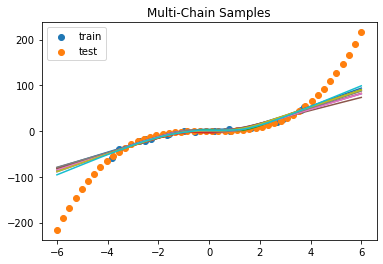

In [11]:
# Take the last state of each chain as a sample to be plotted.
samples = [MLP.flatten_params(c.position_trajectory[-1], param_shapes=net.param_shapes, unflatten=True) for c in hmc_chains.chains]

test_x = data.input_to_torch_tensor(data.get_test_inputs(), device, mode='inference')

plt.title('Multi-Chain Samples')
plt.scatter(data.get_train_inputs(), data.get_train_outputs(), label='train')
plt.scatter(data.get_test_inputs(), data.get_test_outputs(), label='test')

sample_idx = range(len(samples))

for idx in sample_idx:
    test_preds = net.forward(test_x, weights=samples[idx])
    
    plt.plot(data.get_test_inputs(), test_preds.detach().cpu().numpy()) #, label='sample_%d' % idx)

plt.legend()
plt.show()    

# No U-Turn Sampler

As the performance of HMC depends highly on its two leapfrog hyperparameters ($\epsilon$ and $L$), [NUTS](https://arxiv.org/abs/1111.4246) has been proposed to eliminate the need for estimating $L$. We show the usage of this algorithm by repeating some the experiments above.

## Sampling from a 1D normal distribution via NUTS

10/06/2021 06:19:28 PM - DEBUG - NUTS state 1: Current Potential Energy: 1.109704 - Acceptance probability: 100.00%.
10/06/2021 06:19:30 PM - DEBUG - NUTS state 101: Current Potential Energy: 1.001174 - Acceptance probability: 100.00%.
10/06/2021 06:19:32 PM - DEBUG - NUTS state 201: Current Potential Energy: 1.058935 - Acceptance probability: 100.00%.
10/06/2021 06:19:33 PM - DEBUG - NUTS state 301: Current Potential Energy: 0.952047 - Acceptance probability: 100.00%.
10/06/2021 06:19:35 PM - DEBUG - NUTS state 401: Current Potential Energy: 0.930809 - Acceptance probability: 100.00%.
10/06/2021 06:19:37 PM - DEBUG - NUTS state 501: Current Potential Energy: 1.073418 - Acceptance probability: 100.00%.
10/06/2021 06:19:38 PM - DEBUG - NUTS state 601: Current Potential Energy: 1.024458 - Acceptance probability: 100.00%.
10/06/2021 06:19:40 PM - DEBUG - NUTS state 701: Current Potential Energy: 1.128670 - Acceptance probability: 100.00%.
10/06/2021 06:19:41 PM - DEBUG - NUTS state 801: C

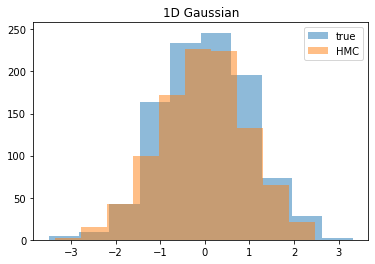

In [12]:
target_dist = Normal(torch.zeros(1,).to(device), 1.)
target_samples = target_dist.sample((1000,))

burn_in = 50

nuts = NUTS(target_dist.sample(), lambda q : -target_dist.log_prob(q), stepsize=.05, delta_max=1000, 
           inv_mass=1., logger=logger, log_interval=100, writer=writer,
           writer_tag='gauss1d/')
nuts.simulate_chain(1000+burn_in)
print('Overall Acceptance Probability: %.2f%%' % (nuts.acceptance_probability * 100))

nuts.clear_position_trajectory(n=burn_in)
nuts_samples = torch.cat(nuts.position_trajectory).detach().cpu().numpy()

print('Empirical mean: true samples %f - HMC samples %f' % (target_samples.mean().item(), nuts_samples.mean().item()))
print('Empirical std: true samples %f - HMC samples %f' % (target_samples.std().item(), nuts_samples.std().item()))

plt.title('1D Gaussian')
plt.hist(target_samples.cpu().numpy(), alpha=.5, label='true')
plt.hist(nuts_samples, alpha=.5, label='HMC')
plt.legend()
plt.show()

## A Bayesian Neural Network with NUTS samples

10/06/2021 06:19:46 PM - DEBUG - NUTS state 1: Current Potential Energy: 605.797058 - Acceptance probability: 100.00%.
10/06/2021 06:20:06 PM - DEBUG - NUTS state 51: Current Potential Energy: 461.895935 - Acceptance probability: 100.00%.
10/06/2021 06:20:27 PM - DEBUG - NUTS state 101: Current Potential Energy: 476.751251 - Acceptance probability: 100.00%.
10/06/2021 06:20:48 PM - DEBUG - NUTS state 151: Current Potential Energy: 478.271851 - Acceptance probability: 100.00%.
10/06/2021 06:21:08 PM - DEBUG - NUTS state 201: Current Potential Energy: 481.983948 - Acceptance probability: 100.00%.
10/06/2021 06:21:29 PM - DEBUG - NUTS state 251: Current Potential Energy: 480.374786 - Acceptance probability: 100.00%.
10/06/2021 06:21:50 PM - DEBUG - NUTS state 301: Current Potential Energy: 468.789398 - Acceptance probability: 100.00%.
10/06/2021 06:22:11 PM - DEBUG - NUTS state 351: Current Potential Energy: 476.997314 - Acceptance probability: 100.00%.
10/06/2021 06:22:32 PM - DEBUG - NU

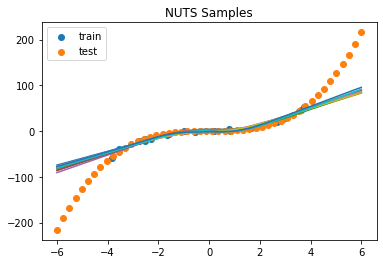

In [13]:
# Reinitialize network randomly and use init as initial position.
net.custom_init()
initial_position = MLP.flatten_params(net.internal_params)

# Generate chain and simulate.
nuts = NUTS(initial_position, pot_energy_func, stepsize=.02, delta_max=1000,
            inv_mass=1., logger=logger, log_interval=50, writer=writer,
            writer_tag='reg1d/')
nuts.simulate_chain(1000)
print('Overall Acceptance Probability: %.2f%%' % (nuts.acceptance_probability * 100))

# Plot a few example states from the chain.
burn_in = 50
nuts.clear_position_trajectory(n=burn_in)
sample_idx = range(0, len(nuts.position_trajectory), len(nuts.position_trajectory)//10)
nuts_samples = [MLP.flatten_params(nuts.position_trajectory[idx], param_shapes=net.param_shapes, unflatten=True) for idx in sample_idx]

test_x = data.input_to_torch_tensor(data.get_test_inputs(), device, mode='inference')

plt.title('NUTS Samples')
plt.scatter(data.get_train_inputs(), data.get_train_outputs(), label='train')
plt.scatter(data.get_test_inputs(), data.get_test_outputs(), label='test')

sample_idx = range(0, len(hmc_samples), len(hmc_samples)//10)

for ii, idx in enumerate(sample_idx):
    test_preds = net.forward(test_x, weights=nuts_samples[ii])
    
    plt.plot(data.get_test_inputs(), test_preds.detach().cpu().numpy()) #, label='sample_%d' % idx)

plt.legend()
plt.show()    

In [14]:
writer.close()